In [42]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [43]:
# Funciones numéricas adicionales
import numpy as np
import statsmodels.api as sm
from datetime import datetime

# Lectura de datos y manejo de Data-sets
import pandas as pd

# Datos
import yfinance as yfin

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones para iterar sobre estructuras especificas
import itertools

# Funciones para optimizar
from scipy.optimize import minimize

In [44]:
%pip install fredapi
from fredapi import Fred

Note: you may need to restart the kernel to use updated packages.


In [45]:
# FRED_API_KEY
fred = Fred(api_key='a3d8a45391e92cc5c30c9c255819c138')

## Punto 1: Definir alcance y Datos

In [46]:
fechaInicio = "2015-01-01"
fechaFin = "2025-01-01"
# El analisis se realizara con una frecuencia diaria inicialmente

fechaInicio_dt = pd.to_datetime(fechaInicio)
fechaFin_dt = pd.to_datetime(fechaFin)

# Apple, Sony Group Co, Garmin Ltd.,
# Logitech Intl., QualComm,
# SP500
tickers = [
    # Salud – Farmacéutica (8)
    "JNJ", "PFE", "MRK", "BMY", "ABBV", "^GSPC"
]

In [47]:
# Descargamos datos FRED
sofr = pd.DataFrame(fred.get_series('SOFR', fechaInicio_dt, fechaFin_dt))
sofr  = sofr .dropna()
sofr.index.names = ['Date']
sofr.columns = ["SOFR"]
sofr["SOFR"] = sofr["SOFR"]/100
sofr

,SOFR
Date,
2018-04-03,0.0183
2018-04-04,0.0174
2018-04-05,0.0175
2018-04-06,0.0175
2018-04-09,0.0175
...,...
2024-12-24,0.0440
2024-12-26,0.0453
2024-12-27,0.0446


In [48]:
SOFR = sofr.iloc[-1]['SOFR']
SOFR

np.float64(0.0449)

In [49]:
# Calculate the monthly average
monthly_sofr = sofr.resample('ME').mean()
display(monthly_sofr)

,SOFR
Date,
2018-04-30,0.017420
2018-05-31,0.017305
2018-06-30,0.018367
2018-07-31,0.019138
2018-08-31,0.019174
...,...
2024-08-31,0.053327
2024-09-30,0.051455
2024-10-31,0.048491


In [50]:
# Descargar precios diarios ajustados de Empresas
df = pd.DataFrame()

# Intervalos diarios
for symbol in tickers:
    df[symbol] = yfin.download(
        symbol,
        start=fechaInicio_dt,
        end=fechaFin_dt,
        interval="1d"
    )["Close"]

/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%*******

## Punto 2: Analisis por Activo


#### Obtener Precio Actual de los activos

In [51]:
precios_actuales = {}

for t in tickers[:-1]:
    data = yfin.Ticker(t).history(period="1d")
    precios_actuales[t] = data["Close"][0]

precios_actuales

/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/1291272587.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precios_actuales[t] = data["Close"][0]
/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/1291272587.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precios_actuales[t] = data["Close"][0]
/var/folders/r4/gt1dv7gn3x7frvp7ct9s1g_h0000gn/T/ipykernel_36385/1291272587.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

{'JNJ': np.float64(206.5399932861328),
 'PFE': np.float64(25.307100296020508),
 'MRK': np.float64(102.4749984741211),
 'BMY': np.float64(49.0099983215332),
 'ABBV': np.float64(224.42100524902344)}

#### Obtener Dividendos desde fecha Inicio hasta fecha Fin

In [52]:
dividendos = {}

for t in tickers[:-1]:
    data = yfin.Ticker(t).dividends         # this is a panda series
    data = data.loc[fechaInicio:fechaFin]   # filter by data range
    dividendos[t] = data                                         

### Graficar Dividend Yield Historico 5 Empresas

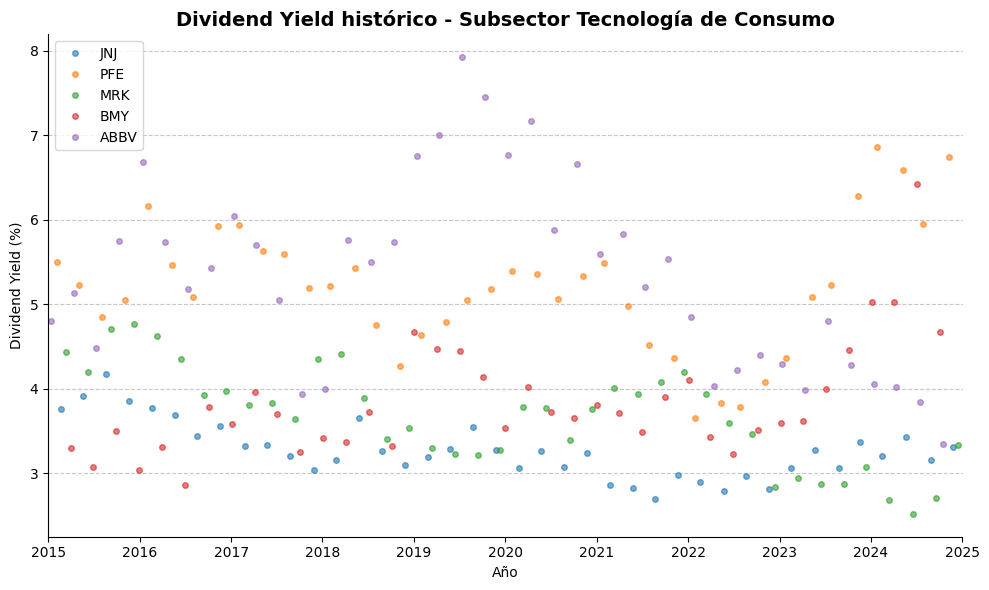

In [53]:
plt.figure(figsize=(10,6))

all_yields = []
dividend_yield_final = {}

for t, d in dividendos.items():
    precios = yfin.download(t, start=fechaInicio_dt, end=fechaFin_dt, auto_adjust=True, progress=False)["Close"]
    
    if hasattr(precios.index, 'tz') and precios.index.tz is not None:
        precios.index = precios.index.tz_localize(None)
    if hasattr(d.index, 'tz') and d.index.tz is not None:
        d.index = d.index.tz_localize(None)
    
    # Combinar dividendos y precios
    df_temp = pd.concat([d, precios], axis=1).dropna()
    df_temp.columns = ["Dividendo", "Precio"]
    
    # TODO: Revisar la suposición trimestral
    
    # Calcular Dividend Yield (anualizado, suposición trimestral)
    df_temp["Dividend Yield"] = (df_temp["Dividendo"] * 4) / df_temp["Precio"]

    # Obtener el ultimo dy antes de fechaFin
    df_trimmed = df_temp[df_temp.index <= fechaFin_dt]
    if len(df_trimmed) > 0:
        dividend_yield_final[t] = df_trimmed["Dividend Yield"].iloc[-1]
    else:
        dividend_yield_final[t] = None
    
    # Graficar con puntos y línea discontinua
    plt.plot(df_temp.index, df_temp["Dividend Yield"]*100, linestyle=" ", marker="o", markersize=4, linewidth=0.6, label=t, alpha=0.6)

    # Store yields for average calculation
    all_yields.append(df_temp["Dividend Yield"] * 100)
    
# Estilo tipo The Economist
plt.title("Dividend Yield histórico - Subsector Tecnología de Consumo", fontsize=14, fontweight="bold")
plt.ylabel("Dividend Yield (%)")
plt.xlabel("Año")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

# Límites del eje x
plt.xlim(fechaInicio_dt, fechaFin_dt)

plt.tight_layout()
plt.show()

### Dividend Yield Promedo

In [54]:
# Calculate the average of the last dividend yield for each ticker
# Filtrar solo valores válidos (no None)
valid_yields = [dy for dy in dividend_yield_final.values() if dy is not None]

if len(valid_yields) > 0:
    average_last_yield = np.mean(valid_yields) * 100   # convertir a %
    print(f"Promedio de los últimos dividend yield hasta fechaFin: {average_last_yield:.2f}%")
else:
    average_last_yield = None
    print("No se encontraron dividend yields válidos en el período analizado.")

Promedio de los últimos dividend yield hasta fechaFin: 4.28%


#### Graficar dividendos de 5 empresas escogidas

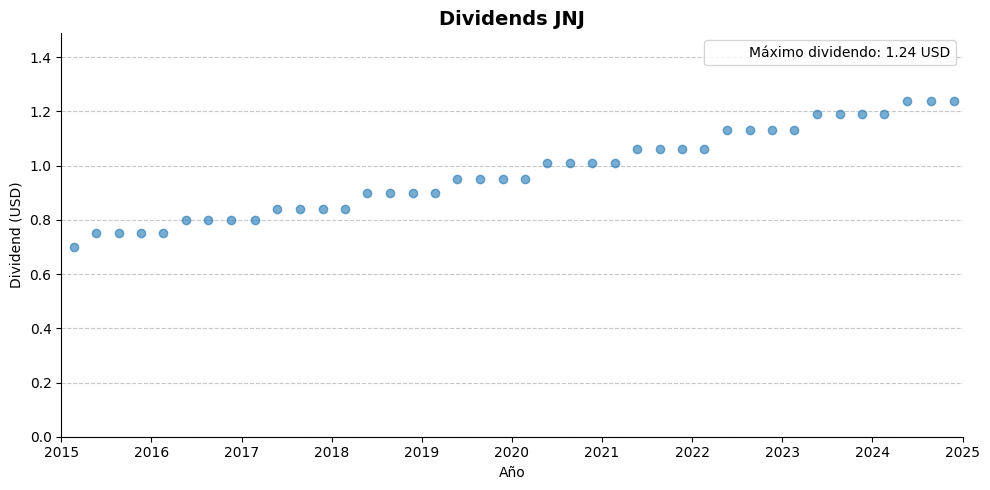

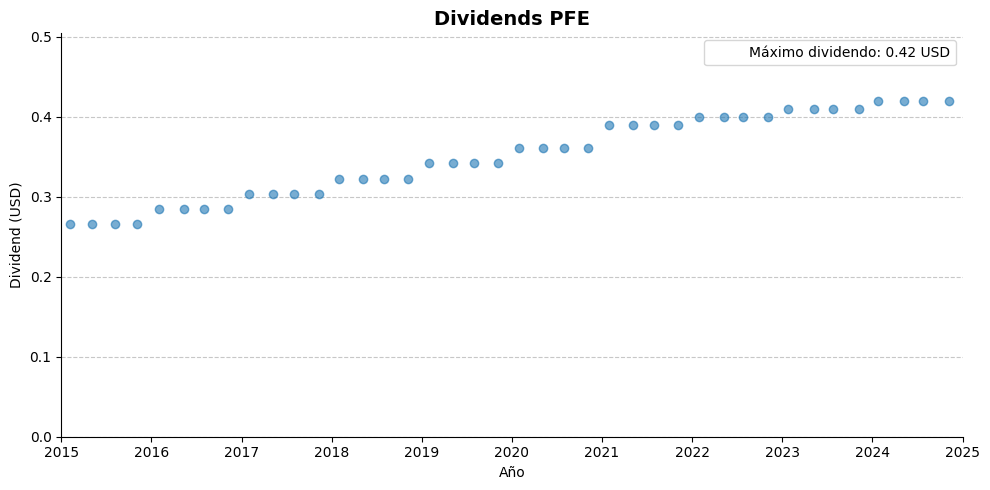

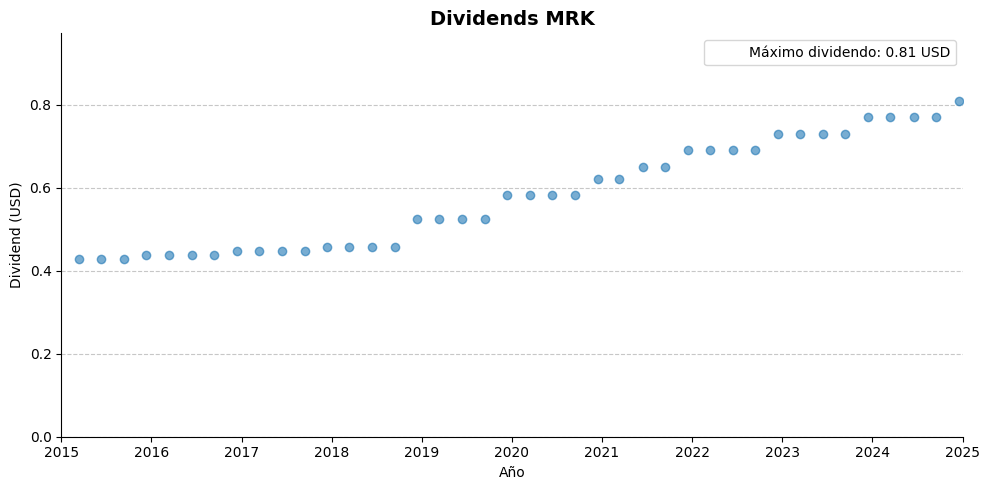

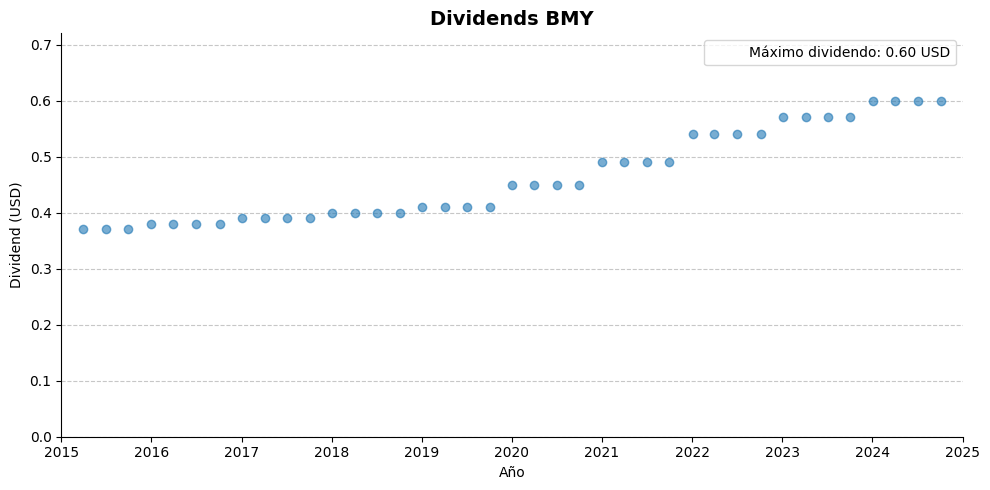

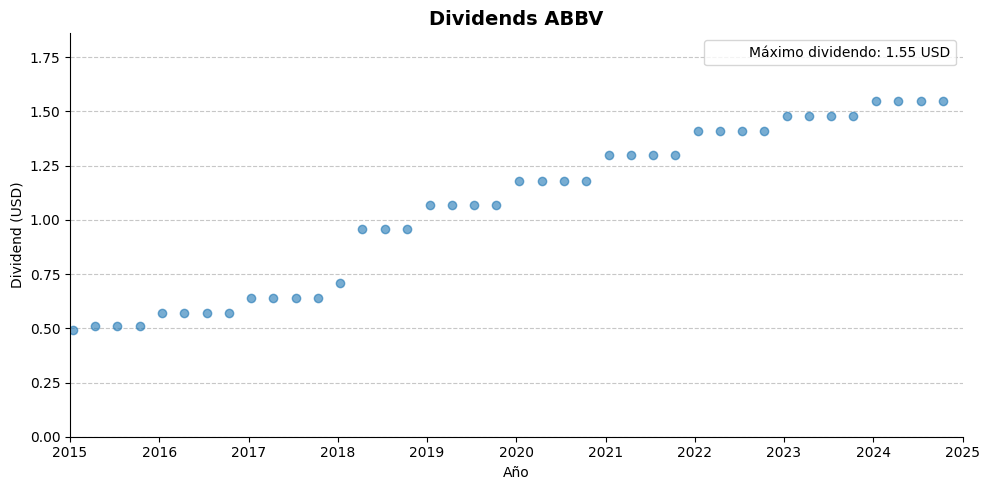

In [55]:
for t, d in dividendos.items():
    # --- Gráfica ---
    plt.figure(figsize=(10,5))
    plt.plot(d.index, d, linestyle=" ", marker="o", color="#1f77b4", linewidth=1.5, alpha=0.6)

    # Estilo tipo The Economist
    plt.title(f"Dividends {t}", fontsize=14, fontweight="bold")
    plt.ylabel("Dividend (USD)")
    plt.xlabel("Año")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Límites del eje x
    plt.xlim(fechaInicio_dt, fechaFin_dt)

    # Mostrar máximo
    plt.ylim(0, d.max() * 1.2)
    plt.plot([], [], ' ', label=f"Máximo dividendo: {d.max():.2f} USD")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Ratios de Valoracion y Apalancamiento

In [56]:
ratios = {}

for t in tickers[:-1]:
    stock = yfin.Ticker(t)

    # --- Market Cap (use price at fechaFin and shares outstanding at fechaFin) ---
    hist = stock.history(
        start=fechaFin_dt - pd.Timedelta(days=3),
        end=fechaFin_dt + pd.Timedelta(days=1)
    )
    
    if len(hist) > 0:
        price = hist["Close"].iloc[-1]
    else:
        price = None
    
    shares_outstanding = stock.info.get("sharesOutstanding")
    if isinstance(shares_outstanding, (int, float)) and shares_outstanding > 0:
        if price:
            market_cap = price * shares_outstanding
        else:
            market_cap = None
    else:
        market_cap = None
    
    # Balance general (antes de fechaFin)
    bs = stock.quarterly_balance_sheet

    if bs is not None and bs.shape[1] > 0:
        bs_cols = [pd.to_datetime(c) for c in bs.columns]
        valid_dates = [d for d in bs_cols if d <= fechaFin_dt]

        if valid_dates:
            closest_date = max(valid_dates)
            # seleccionar la columna asociada
            balance = bs.loc[:, closest_date]
        else:
            balance = None
    else:
        balance = None
    
    total_debt = None
    if balance is not None:
        for key in ["Total Debt", "Long Term Debt", "Short Long Term Debt"]:
            if key in balance.index:
                total_debt = balance.loc[key]
                break

    # Si no se encontró deuda
    if total_debt is None:
        total_debt = 0
                
    # Total Equity
    total_equity = None
    val = balance.loc["Stockholders Equity"]
    total_equity = float(val) if not hasattr(val, "__len__") else float(val.iloc[0])
    
    # Price to Book
    if total_equity is not None and shares_outstanding is not None and shares_outstanding > 0:
        book_value_per_share = total_equity / shares_outstanding
        price_to_book = price / book_value_per_share
    else:
        price_to_book = None
    
    # Debt to Equity
    if total_debt is not None and total_equity is not None and total_equity != 0:
        debt_to_equity = total_debt / total_equity
    else:
        debt_to_equity = None
    
    # Cálculo Debt-to-Value ratio
    if market_cap and total_debt:
        debt_to_value = total_debt / (total_debt + market_cap)
    else:
        debt_to_value = None

    ratios[t] = {
        "PriceAtFechaFin": price,
        "SharesOutstanding": shares_outstanding,
        "MarketCap": market_cap,
        "TotalDebt": total_debt,
        "PriceToBook": price_to_book,
        "DebtToEquity": debt_to_equity,
        "DebtToValue": debt_to_value,
        "DividendYield": dividend_yield_final.get(t),
        "TotalEquity": total_equity,
    }

df_ratios = pd.DataFrame(ratios).T
df_ratios

,PriceAtFechaFin,SharesOutstanding,MarketCap,TotalDebt,PriceToBook,DebtToEquity,DebtToValue,DividendYield,TotalEquity
JNJ,140.324554,2.409295e+09,3.380833e+11,3.663400e+10,4.729099,0.512435,0.097764,0.033082,7.149000e+10
PFE,24.739927,5.685708e+09,1.406640e+11,6.364900e+10,1.594776,0.721619,0.311527,0.067424,8.820300e+10
MRK,96.695084,2.482023e+09,2.399994e+11,3.711100e+10,5.182117,0.801308,0.133921,0.033313,4.631300e+10
BMY,53.881691,2.035753e+09,1.096898e+11,5.120000e+10,6.715018,3.134374,0.318230,0.046688,1.633500e+10
ABBV,171.696518,1.767385e+09,3.034538e+11,6.714400e+10,91.264297,20.193684,0.181178,0.033445,3.325000e+09


### Calcular Costo de equity vía CAPM (r)

In [57]:
# Supongamos tasa libre de riesgo (Treasury 10 años)
r_f = 0.0444  # 4.5%
market_premium_override = 0.055 # Fallback por si valor da negativo o 0...

# diario
prices = df.loc[fechaInicio_dt:fechaFin_dt].copy()   # df debe contener columnas para tickers y '^GSPC'
prices = prices.dropna(how="all")  # elimina filas vacías

# diario
rend_log = np.log(prices).diff().dropna()
market = rend_log["^GSPC"]

# anual
hist_market_premium = market.mean() * 252 - r_f

if hist_market_premium <= 0:
        market_premium = market_premium_override
else:
    market_premium = hist_market_premium

k_equity = {}

for t in rend_log.columns:
    if t == "^GSPC":
        continue
    
    # diario
    Ri = rend_log[t].dropna()
    
    # Alinear fechas con el mercado
    common_idx = Ri.index.intersection(market.index)
    Ri_al = Ri.loc[common_idx]
    M_al = market.loc[common_idx]    

    # Beta por cov/var
    beta = Ri_al.cov(M_al) / M_al.var()

    # Cost of equity 
    k = r_f + beta * market_premium
    k_equity[t] = k

# --- Resultado: diccionario con k por ticker (diario)---
k_equity

{'JNJ': np.float64(0.07712459480421427),
 'PFE': np.float64(0.08162891681114502),
 'MRK': np.float64(0.07923488224212766),
 'BMY': np.float64(0.07891351018519047),
 'ABBV': np.float64(0.08591177792943128)}

### Valuacion por Dividendos modelo Gordon & Shapiro

In [58]:
DDM = {}

for t in tickers[:-1]:
    tk = yfin.Ticker(t)
    
    # Dividendos hasta fechaFin
    divs = tk.dividends.loc[:fechaFin]
    
    # Dividendos recientes (último año)
    D0 = divs.iloc[-4:].sum()
    
    # Crecimiento histórico de dividendos (CAGR a 5 años)
    divs_5y = divs.loc[divs.index[-1] - pd.DateOffset(years=5):]
    
    if len(divs_5y) >= 8:
        first = divs_5y[:4].sum()
        last  = divs_5y[-4:].sum()
        years = divs_5y.index[-1].year - divs_5y.index[0].year
        g = (last/first)**(1/years) - 1
    else:
        g = 0.04  # default
    
    # Precio a fechaFin
    hist = tk.history(start=fechaFin_dt, end=fechaFin_dt + pd.Timedelta(days=2))
    price = hist["Close"].iloc[0]
    
    # Valuación DDM
    D1 = D0 * (1 + g)
    r_scalar = k_equity[t]
    
    if r_scalar > g:
        V = D1 / (r_scalar - g)
    else:
        V = None
    
    DDM[t] = {
        "D0": D0,
        "g": g,
        "D1": D1 if r_scalar else None,
        "Valor_DDM": V,
        "Precio_Mercado": price,
        "Upside_%": (V/price - 1)*100 if V else None
    }
    
# Mostrar resultados
for t, v in DDM.items():
    # Formatear valores con manejo de None
    valor_teorico = f"${v['Valor_DDM']:.2f}" if v['Valor_DDM'] is not None else "N/A"
    precio_mercado = f"${v['Precio_Mercado']:.2f}" if v['Precio_Mercado'] is not None else "N/A"
    upside = f"{v['Upside_%']:+.2f}%" if v['Upside_%'] is not None else "N/A"
    
    print(
        f"{t}: "
        f"Precio teórico = {valor_teorico} | "
        f"Precio mercado = {precio_mercado} | "
        f"Upside = {upside}"
    )

JNJ: Precio teórico = $222.81 | Precio mercado = $139.74 | Upside = +59.45%
PFE: Precio teórico = $40.85 | Precio mercado = $24.81 | Upside = +64.64%
MRK: Precio teórico = $435.55 | Precio mercado = $96.39 | Upside = +351.84%
BMY: Precio teórico = $593.74 | Precio mercado = $54.10 | Upside = +997.47%
ABBV: Precio teórico = $432.46 | Precio mercado = $173.38 | Upside = +149.43%


### Beta, Alpha

In [59]:
alpha_dict = {}
beta_dict = {}
beta_u_dict = {}

# Esto servira para el punto 3...
CAPM_daily = {}
CAPM_anual = {}

Rm_anual = rend_log["^GSPC"].mean() * 252 # retornos anuales del mercado
r_f_daily = r_f / 252

for t in tickers[:-1]:
    Ri = rend_log[t].dropna()        
    
    Rm = rend_log["^GSPC"].loc[Ri.index]   # alinear fechas
    
    # beta diario
    beta = Ri.cov(Rm) / Rm.var()
    beta_dict[t] = beta
    
    # expected return diario y anual
    market_premium_daily = market_premium_daily = Rm.mean() - r_f_daily
    expected_return = r_f + beta * (Rm - r_f)
    expected_daily = r_f_daily + beta * market_premium_daily
    expected_anual = expected_daily * 252
    
    CAPM_daily[t] = expected_daily
    CAPM_anual[t] = expected_anual
    
    # alpha diario 
    alpha = Ri.mean() - expected_daily
    alpha_dict[t] = alpha
    
    # beta desapalancado
    if t in ratios:     # usando el df se construyo anteriormente
        market_cap = ratios[t]["MarketCap"]
        debt       = ratios[t]["TotalDebt"]

        if market_cap and debt and (market_cap + debt) > 0:
            beta_u = (market_cap / (market_cap + debt)) * beta
        else:
            beta_u = None
    else:
        beta_u = None

    beta_u_dict[t] = beta_u
    
for t in tickers[:-1]:
    print(
        f"{t}: Beta (beta apalancado)={beta_dict.get(t):.2f}, "
        f"Alpha={alpha_dict.get(t):.4f}, "
        f"Beta_u (beta desapalancado sin impuestos)={beta_u_dict.get(t)}"
    )

JNJ: Beta (beta apalancado)=0.54, Alpha=-0.0001, Beta_u (beta desapalancado sin impuestos)=0.4855418510264898
PFE: Beta (beta apalancado)=0.61, Alpha=-0.0002, Beta_u (beta desapalancado sin impuestos)=0.4215021327837502
MRK: Beta (beta apalancado)=0.57, Alpha=0.0000, Beta_u (beta desapalancado sin impuestos)=0.4961398302906073
BMY: Beta (beta apalancado)=0.57, Alpha=-0.0002, Beta_u (beta desapalancado sin impuestos)=0.3869539689893388
ABBV: Beta (beta apalancado)=0.68, Alpha=0.0002, Beta_u (beta desapalancado sin impuestos)=0.558976431009416


## Punto 3: Retornos y riesgo a nivel activo (Estadistica)

In [60]:
print("=== Retornos esperados por CAPM (diarios)===")
for t, er in CAPM_daily.items():
    print(f"{t}: {er:.2%}")
    
print("\n=== Retornos esperados por CAPM (anuales)===")
for t, er in CAPM_anual.items():
    print(f"{t}: {er:.2%}")

vol_diaria = {}
vol_anual = {}
volatilidades = {}

for t in tickers[:-1]:
    vol_diaria[t] = rend_log[t].std()
    vol_anual[t] = vol_diaria[t] * np.sqrt(252)
    
    volatilidades[t] = {
        'Vol. Diaria (%)': vol_diaria[t] * 100,
        'Vol. Anual (%)': vol_anual[t] * 100
    }

df_vol = pd.DataFrame(volatilidades).T
print("\nVolatilidades:")
print(df_vol.round(2))

# Matriz de covarianzas (diaria)
cov_matrix = rend_log.cov()
print(f"\nMatriz de covarianzas: \n {cov_matrix}")

# Matriz de correlacion
corr_matrix = rend_log.corr()
print(f"\nMatriz de correlacion: \n {corr_matrix}")

=== Retornos esperados por CAPM (diarios)===
JNJ: 0.03%
PFE: 0.03%
MRK: 0.03%
BMY: 0.03%
ABBV: 0.03%

=== Retornos esperados por CAPM (anuales)===
JNJ: 7.71%
PFE: 8.16%
MRK: 7.92%
BMY: 7.89%
ABBV: 8.59%

Volatilidades:
      Vol. Diaria (%)  Vol. Anual (%)
JNJ              1.14           18.08
PFE              1.46           23.19
MRK              1.36           21.61
BMY              1.57           24.87
ABBV             1.69           26.86

Matriz de covarianzas: 
             JNJ       PFE       MRK       BMY      ABBV     ^GSPC
JNJ    0.000130  0.000087  0.000081  0.000079  0.000083  0.000068
PFE    0.000087  0.000213  0.000093  0.000098  0.000107  0.000078
MRK    0.000081  0.000093  0.000185  0.000078  0.000097  0.000073
BMY    0.000079  0.000098  0.000078  0.000245  0.000105  0.000072
ABBV   0.000083  0.000107  0.000097  0.000105  0.000286  0.000087
^GSPC  0.000068  0.000078  0.000073  0.000072  0.000087  0.000127

Matriz de correlacion: 
             JNJ       PFE       MRK    

## Punto 4: Construcción del portafolio

In [61]:
import numpy as np
import pandas as pd

# ==============================================================================
# PUNTO 4: SIMULACIÓN DE PORTAFOLIOS (MONTE CARLO) - CORREGIDO
# ==============================================================================

# 1. CALCULAR VARIABLES PREVIAS (Esto es lo que faltaba)
# Usamos los tickers menos el mercado (^GSPC)
activos = tickers[:-1] 

# Matriz de covarianza anualizada
cov_matrix_sliced = cov_matrix.loc[activos, activos]
cov_matrix_anual = cov_matrix_sliced * 252

# Retornos esperados anualizados
expected_returns = rend_log[activos].mean() * 252

# 2. CONFIGURACIÓN DE LA SIMULACIÓN
num_portfolios = 5000
deterministic_results = []
limite_maximo = 0.30  # Restricción: Ningún activo > 30%

print(f"Iniciando simulación de {num_portfolios} portafolios...")
print(f"Restricción de peso máximo por activo: {limite_maximo*100}%")

# 3. BUCLE DE SIMULACIÓN
for _ in range(num_portfolios):
    # Generar pesos aleatorios
    weights = np.random.random(len(activos))
    
    # Normalizar para que sumen 1 (100%)
    weights /= np.sum(weights)
    
    # --- FILTRO DE DIVERSIFICACIÓN ---
    # Si algún peso supera el 30%, descartamos este portafolio y pasamos al siguiente
    if np.any(weights > limite_maximo):
        continue
        
    # Calcular métricas del portafolio simulado
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_anual, weights))
    portfolio_std = np.sqrt(portfolio_variance)
    
    sharpe = (portfolio_return - r_f) / portfolio_std
    
    # Guardar resultados
    deterministic_results.append({
        'Retorno_Anual_%': portfolio_return * 100,
        'Volatilidad_Anual_%': portfolio_std * 100,
        'Sharpe_Ratio': sharpe,
        **{f'{t}_peso': w for t, w in zip(activos, weights)}
    })

# 4. CREAR DATAFRAME Y ORDENAR
df_deterministic = pd.DataFrame(deterministic_results)

# Validar si se generaron portafolios
if not df_deterministic.empty:
    df_deterministic = df_deterministic.sort_values('Sharpe_Ratio', ascending=False)
    
    print(f"\nSe generaron con éxito {len(df_deterministic)} portafolios válidos.")
    print(f"\n{'=' * 80}")
    print(f"Top 5 Portafolios Simulados (Max Sharpe)")
    print(f"{'=' * 80}")
    print(df_deterministic.head(5).to_string(index=False))
else:
    print("Error: No se encontraron portafolios que cumplan la restricción. Intenta subir el límite máximo o aumentar el número de simulaciones.")

Iniciando simulación de 5000 portafolios...
Restricción de peso máximo por activo: 30.0%

Se generaron con éxito 1493 portafolios válidos.

Top 5 Portafolios Simulados (Max Sharpe)
 Retorno_Anual_%  Volatilidad_Anual_%  Sharpe_Ratio  JNJ_peso  PFE_peso  MRK_peso  BMY_peso  ABBV_peso
        8.848915            17.332504      0.254373  0.285896  0.106688  0.287419  0.024873   0.295125
        8.748460            17.343365      0.248421  0.260725  0.008161  0.291832  0.145518   0.293763
        8.616840            17.342634      0.240842  0.245784  0.014128  0.287707  0.163328   0.289052
        8.556432            17.192825      0.239427  0.275556  0.015647  0.284700  0.147574   0.276523
        8.611512            17.446800      0.239099  0.204578  0.146295  0.297926  0.059022   0.292179


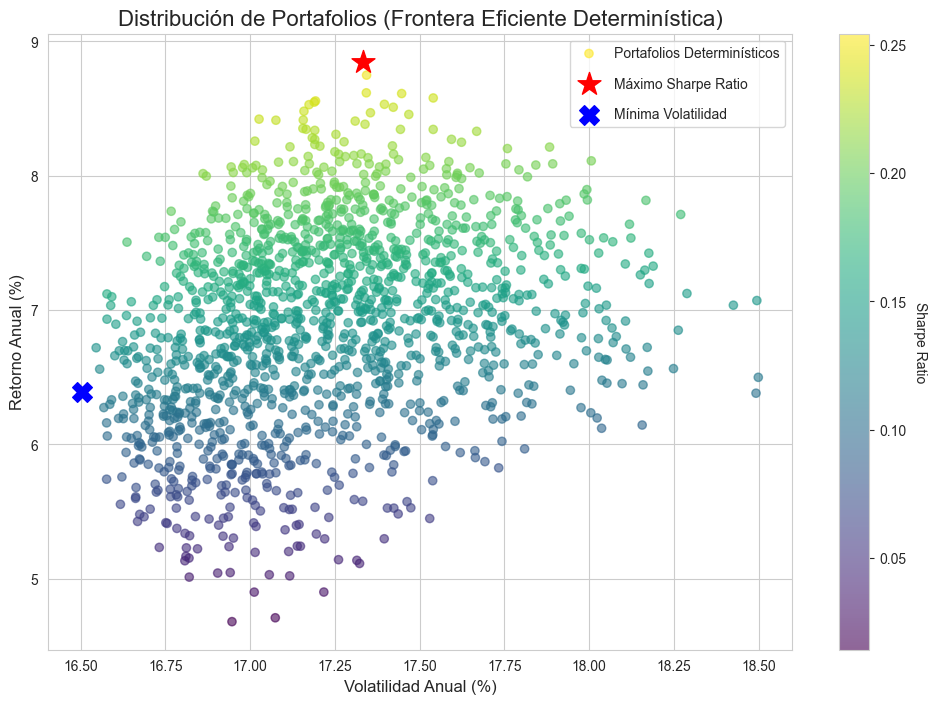


DESGLOSE DE PORTAFOLIOS ÓPTIMOS
                     Máximo Sharpe Ratio  Mínima Volatilidad
Retorno_Anual_%                   8.8489              6.3908
Volatilidad_Anual_%              17.3325             16.5040
Sharpe_Ratio                      0.2544              0.1182
JNJ_peso                          0.2859              0.2953
PFE_peso                          0.1067              0.1702
MRK_peso                          0.2874              0.2415
BMY_peso                          0.0249              0.1891
ABBV_peso                         0.2951              0.1038


In [62]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# --- 1. Graficar todos los portafolios (la distribución) ---
# Usamos el Sharpe Ratio para colorear los puntos, visualizando cuáles son los mejores.
scatter = plt.scatter(
    df_deterministic['Volatilidad_Anual_%'],
    df_deterministic['Retorno_Anual_%'],
    c=df_deterministic['Sharpe_Ratio'],  # Color basado en el Sharpe Ratio
    cmap='viridis',
    marker='o',
    alpha=0.6,
    label='Portafolios Determinísticos'
)

# Añadir barra de color para el Sharpe Ratio
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)


# --- 2. Identificar y resaltar los portafolios clave ---

# a) Portafolio de Máximo Sharpe Ratio (Punto de Tangencia)
# El primer registro después de la ordenación
max_sharpe_portfolio = df_deterministic.iloc[0] 

# b) Portafolio de Mínima Volatilidad
min_volatility_portfolio = df_deterministic.loc[
    df_deterministic['Volatilidad_Anual_%'].idxmin()
]

# Resaltar el Portafolio de Máximo Sharpe
plt.scatter(
    max_sharpe_portfolio['Volatilidad_Anual_%'],
    max_sharpe_portfolio['Retorno_Anual_%'],
    color='red',
    marker='*',
    s=300, # Tamaño grande de estrella
    label='Máximo Sharpe Ratio'
)

# Resaltar el Portafolio de Mínima Volatilidad
plt.scatter(
    min_volatility_portfolio['Volatilidad_Anual_%'],
    min_volatility_portfolio['Retorno_Anual_%'],
    color='blue',
    marker='X',
    s=200, # Tamaño de X
    label='Mínima Volatilidad'
)

# --- 3. Etiquetas y Títulos ---
plt.title('Distribución de Portafolios (Frontera Eficiente Determinística)', fontsize=16)
plt.xlabel('Volatilidad Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.legend(labelspacing=1.2)
plt.grid(True)
plt.show()

# Columnas deseadas fijas
columnas_deseadas = [
    'Retorno_Anual_%',
    'Volatilidad_Anual_%',
    'Sharpe_Ratio',
]

# Agregar columnas de pesos automaticamente
columnas_deseadas += [f'{t}_peso' for t in tickers[:-1]] 

portfolios_a_mostrar = pd.DataFrame([max_sharpe_portfolio, min_volatility_portfolio])

portfolios_final = portfolios_a_mostrar[columnas_deseadas].copy()
portfolios_final.index = ['Máximo Sharpe Ratio', 'Mínima Volatilidad']

df_final_t = portfolios_final.T

print(f"\n{'=' * 70}")
print("DESGLOSE DE PORTAFOLIOS ÓPTIMOS")
print(f"{'=' * 70}")

# Usar el formato .to_string() para una impresión limpia
print(df_final_t.to_string(float_format='%.4f'))

## Punto 5: Optimización y fronteras eficiente

### Portafolio de Mínima Varianza (MVP)

El siguiente codigo utiliza un método analítico de optimización para encontrar los pesos exactos de los portafolios óptimos, en lugar de depender de la aproximación de una muestra discreta.

Calcula el Portafolio de Mínima Varianza (MVP) encontrando los pesos w que minimizan la volatilidad. 

Se tiene como funcion objetivo minimizar la varianza (volatilidad) del portafolio. 

Mientras que como restricciones se tiene que la suma de todos los pesos debe ser igual a 1. Y que no se pueden tener persos negativos (sin ventas en corto). 

In [63]:
# ==============================================================================
# PUNTO 5: OPTIMIZACIÓN ANALÍTICA (CORREGIDO)
# ==============================================================================

# 1. Preparar datos anualizados
# Asegúrate de que 'tickers' y 'rend_log' estén definidos previamente
cov_matrix_sliced_anual = cov_matrix_sliced.loc[tickers[:-1], tickers[:-1]] * 252
cov_matrix_array = cov_matrix_sliced_anual.values
expected_returns = rend_log[tickers[:-1]].mean() * 252

# 2. Definir funciones objetivo
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def neg_sharpe_ratio(weights, expected_returns, cov_matrix):
    er = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return - (er - r_f) / vol

# 3. Configurar Restricciones y Límites
num_assets = len(tickers[:-1])
initial_weights = np.array(num_assets * [1./num_assets]) 

# --- AQUÍ ESTÁ EL CAMBIO CLAVE ---
# Límite del 30% para que el modelo pueda moverse del 20%
limite_maximo = 0.30 
bounds = tuple([(0, limite_maximo) for asset in range(num_assets)])

# Restricción: La suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# 4. Calcular Mínima Varianza (MVP)
min_var_results = minimize(
    portfolio_volatility, 
    initial_weights, 
    args=(cov_matrix_sliced,), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

w_min_var = min_var_results.x
er_min_var = portfolio_return(w_min_var, expected_returns)
vol_min_var = portfolio_volatility(w_min_var, cov_matrix_array)
sharpe_min_var = (er_min_var - r_f) / vol_min_var

# 5. Calcular Máximo Sharpe (PMR)
pmr_results = minimize(
    neg_sharpe_ratio, 
    initial_weights, 
    args=(expected_returns, cov_matrix_array), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

w_pmr = pmr_results.x
er_pmr = portfolio_return(w_pmr, expected_returns)
vol_pmr = portfolio_volatility(w_pmr, cov_matrix_array)
sharpe_pmr = (er_pmr - r_f) / vol_pmr

# 6. Mostrar Resultados
print("\n" + "="*60)
print(" COMPARACIÓN DE PORTAFOLIOS ÓPTIMOS (Restricción Max 30%)")
print("="*60)
print(f"{'Métrica':<25} | {'Mínima Varianza':<20} | {'Máximo Sharpe':<20}")
print("-" * 73)
print(f"{'Retorno Anual':<25} | {er_min_var:.2%}               | {er_pmr:.2%}")
print(f"{'Volatilidad Anual':<25} | {vol_min_var:.2%}               | {vol_pmr:.2%}")
print(f"{'Sharpe Ratio':<25} | {sharpe_min_var:.4f}               | {sharpe_pmr:.4f}")
print("-" * 73)
print("ASIGNACIÓN DE PESOS:")
for t, w_mvp, w_pmr in zip(tickers[:-1], w_min_var, w_pmr):
    print(f"{t:<25} | {w_mvp:.2%}               | {w_pmr:.2%}")
print("="*60)


 COMPARACIÓN DE PORTAFOLIOS ÓPTIMOS (Restricción Max 30%)
Métrica                   | Mínima Varianza      | Máximo Sharpe       
-------------------------------------------------------------------------
Retorno Anual             | 6.45%               | 9.02%
Volatilidad Anual         | 16.50%               | 17.34%
Sharpe Ratio              | 0.1217               | 0.2643
-------------------------------------------------------------------------
ASIGNACIÓN DE PESOS:
JNJ                       | 30.00%               | 30.00%
PFE                       | 18.01%               | 5.49%
MRK                       | 23.56%               | 30.00%
BMY                       | 17.38%               | 4.51%
ABBV                      | 11.05%               | 30.00%


## Trazado de la Frontera Eficiente

Este código utiliza el mismo método analítico de optimización del MVP, pero aplicado de forma iterativa para generar la curva continua de portafolios eficientes.

Calcula la mínima volatilidad posible para un rango predefinido de retornos objetivos (desde el MVP hasta el retorno del mejor activo).

Función Objetivo: Minimizar la varianza (volatilidad) del portafolio.

Restricciones (Iterativas):
La suma de todos los pesos debe ser igual a 1.
El retorno del portafolio debe ser igual al retorno objetivo $\left(R_p = R_p^*\right)$ de la iteración actual.
No se permiten pesos negativos (sin ventas en corto).

Al resolver este problema repetidamente, el resultado es la Frontera Eficiente, la curva matemática que representa la mejor combinación riesgo-retorno posible.

In [64]:
# El retorno mínimo de la frontera es el retorno del MVP.
# El retorno máximo de la frontera será el retorno del activo con el mejor retorno individual.
er_max = np.max(expected_returns) * 1.05 # Ligeramente por encima del mejor activo

# Crear un rango de retornos objetivo para el trazado (50 puntos)
target_returns = np.linspace(er_min_var, er_max, 50) 
frontier_volatilities = []

for target_ret in target_returns:    
    # Restricción 1: Suma de pesos = 1
    # Restricción 2: Retorno del portafolio = Retorno Objetivo
    constraints_frontier = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, expected_returns) - target_ret}
    )
    
    # Minimizar la volatilidad sujeto al Retorno Objetivo
    result = minimize(
        portfolio_volatility, 
        initial_weights, 
        args=(cov_matrix_array,), 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints_frontier
    )
    
    # Guardar la volatilidad obtenida
    frontier_volatilities.append(result.fun)
    
# Guardar resultados para graficar
df_frontier = pd.DataFrame({
    'Retorno Anual (%)': target_returns * 100,
    'Volatilidad Anual (%)': np.array(frontier_volatilities) * 100
})
df_frontier

,Retorno Anual (%),Volatilidad Anual (%)
0,6.448224,16.474151
1,6.618487,16.477526
2,6.788751,16.488079
3,6.959014,16.505797
4,7.129278,16.531058
5,7.299541,16.563463
6,7.469805,16.603972
7,7.640068,16.652384
8,7.810332,16.708630
9,7.980596,16.772631


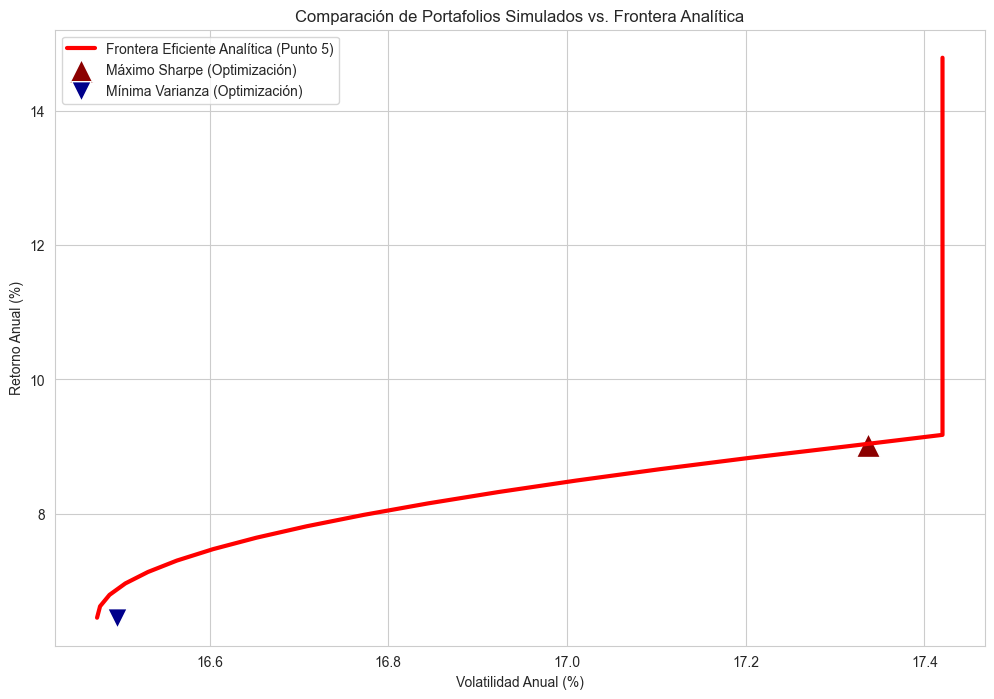

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Graficar la nube de puntos simulados (del Punto 4)
# Asegúrate de cargar tu df_deterministic aquí si no lo tienes
# plt.scatter(df_deterministic['Volatilidad_Anual_%'], df_deterministic['Retorno_Anual_%'], ...)

# Graficar la Curva Analítica de la Frontera Eficiente (Punto 5)
plt.plot(
    df_frontier['Volatilidad Anual (%)'], 
    df_frontier['Retorno Anual (%)'], 
    color='red', 
    linestyle='-', 
    linewidth=3, 
    label='Frontera Eficiente Analítica (Punto 5)'
)

# Resaltar Portafolios Óptimos CALCULADOS POR OPTIMIZACIÓN
plt.scatter(
    vol_pmr * 100, er_pmr * 100, # Multiplicar por 100 para %
    color='darkred', 
    marker='^', s=300, edgecolors='white', 
    label='Máximo Sharpe (Optimización)'
)

plt.scatter(
    vol_min_var * 100, er_min_var * 100, # Multiplicar por 100 para %
    color='darkblue', 
    marker='v', s=200, edgecolors='white',
    label='Mínima Varianza (Optimización)'
)

# #tiquetas y Títulos
plt.title('Comparación de Portafolios Simulados vs. Frontera Analítica')
plt.xlabel('Volatilidad Anual (%)')
plt.ylabel('Retorno Anual (%)')
plt.legend()
plt.grid(True)
plt.show()


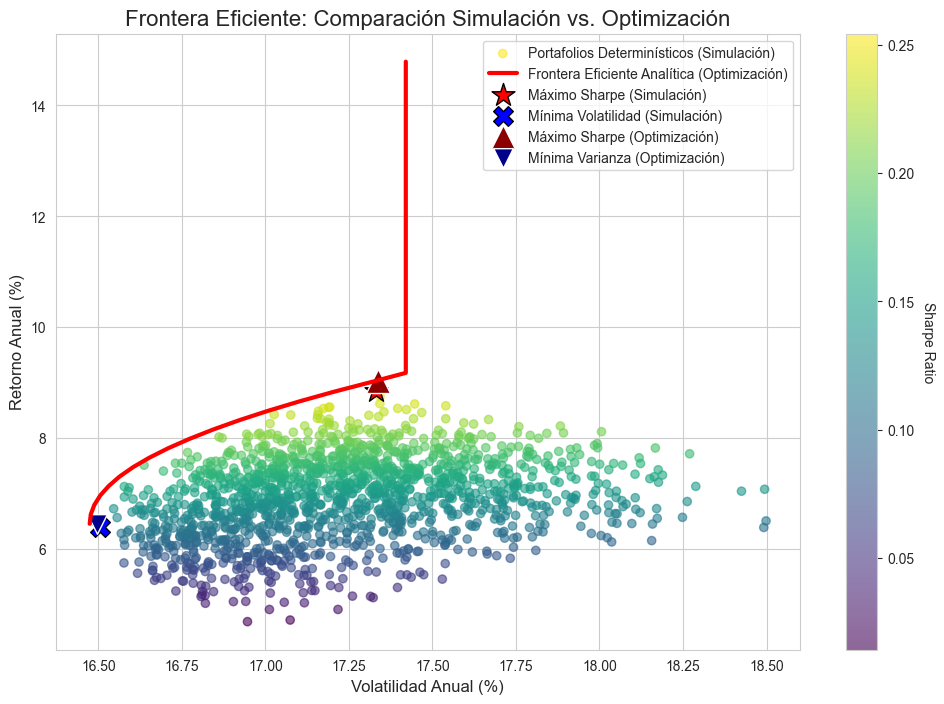

In [66]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# --- A. Graficar todos los portafolios simulados (Punto 4) ---
scatter = plt.scatter(
    df_deterministic['Volatilidad_Anual_%'],
    df_deterministic['Retorno_Anual_%'],
    c=df_deterministic['Sharpe_Ratio'],
    cmap='viridis',
    marker='o',
    alpha=0.6,
    label='Portafolios Determinísticos (Simulación)'
)

# Añadir barra de color para el Sharpe Ratio
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

# --- B. Graficar la Frontera Eficiente Analítica (Punto 5) ---
plt.plot(
    df_frontier['Volatilidad Anual (%)'],
    df_frontier['Retorno Anual (%)'],
    color='red',
    linestyle='-',
    linewidth=3,
    label='Frontera Eficiente Analítica (Optimización)' # Es la curva exacta
)

# --- C. Identificar y resaltar los portafolios clave ---

# a) Portafolio de Máximo Sharpe (de la simulación)
max_sharpe_portfolio = df_deterministic.iloc[0] 

plt.scatter(
    max_sharpe_portfolio['Volatilidad_Anual_%'],
    max_sharpe_portfolio['Retorno_Anual_%'],
    color='red',
    marker='*',
    s=300, 
    edgecolors='black', # Para resaltarlo mejor
    label='Máximo Sharpe (Simulación)'
)

# b) Portafolio de Mínima Volatilidad (de la simulación)
min_volatility_portfolio = df_deterministic.loc[
    df_deterministic['Volatilidad_Anual_%'].idxmin()
]

plt.scatter(
    min_volatility_portfolio['Volatilidad_Anual_%'],
    min_volatility_portfolio['Retorno_Anual_%'],
    color='blue',
    marker='X',
    s=200,
    edgecolors='black',
    label='Mínima Volatilidad (Simulación)'
)

# c) y d) Resaltar Portafolios Óptimos CALCULADOS POR OPTIMIZACIÓN
plt.scatter(
    vol_pmr * 100, er_pmr * 100, # Multiplicar por 100 para %
    color='darkred', 
    marker='^', s=300, edgecolors='white', 
    label='Máximo Sharpe (Optimización)'
)

plt.scatter(
    vol_min_var * 100, er_min_var * 100, # Multiplicar por 100 para %
    color='darkblue', 
    marker='v', s=200, edgecolors='white',
    label='Mínima Varianza (Optimización)'
)

# --- D. Etiquetas y Títulos ---
plt.title('Frontera Eficiente: Comparación Simulación vs. Optimización', fontsize=16)
plt.xlabel('Volatilidad Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()